In [42]:
import os
import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from ultralytics import YOLO
from sklearn.decomposition import PCA
from scipy.cluster.vq import kmeans, vq

In [14]:
PATH = os.path.join(os.getcwd(), 'runs', 'detect', 'Output (n)', 'weights', 'best.pt')
model = YOLO(PATH)


In [28]:
def extract_features(image_path, model, layer_index):
    image = Image.open(image_path)
    preprocess = transforms.Compose([
        transforms.Resize((128 ,128)),
        transforms.ToTensor(),
    ])
    input_tensor = preprocess(image)
    input_batch = input_tensor.unsqueeze(0)
    
    featuers = []
    def hook_fn(module, input, output):
        featuers.append(output)
    
    handle = model.model.model[layer_index].register_forward_hook(hook_fn)

    with torch.no_grad():
        model(input_batch)

    handle.remove()
    return featuers[0]

In [31]:
image_dir = os.path.join(os.getcwd(), 'Clean', 'train', 'images')
image_paths = [os.path.join(image_dir, img) for img in os.listdir(image_dir) if img.endswith('.jpg')]

In [32]:
features_list = []
for image_path in image_paths:
    features = extract_features(image_path, model, 2)
    features_list.append(features.flatten().numpy())


0: 128x128 1 Tumor, 50.3ms
Speed: 0.0ms preprocess, 50.3ms inference, 1.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 1 Tumor, 12.0ms
Speed: 0.0ms preprocess, 12.0ms inference, 1.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 1 Tumor, 11.0ms
Speed: 0.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 (no detections), 12.0ms
Speed: 0.0ms preprocess, 12.0ms inference, 1.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 (no detections), 11.0ms
Speed: 0.0ms preprocess, 11.0ms inference, 1.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 (no detections), 11.0ms
Speed: 0.0ms preprocess, 11.0ms inference, 0.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 (no detections), 11.5ms
Speed: 0.0ms preprocess, 11.5ms inference, 2.0ms postprocess per image at shape (1, 3, 128, 128)

0: 128x128 1 Tumor, 17.9ms
Speed: 0.0ms preprocess, 17.9ms inference, 1.0ms postprocess per 

In [53]:
# Dimensionality reduction using PCA
features_array = np.array(features_list)
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_array)

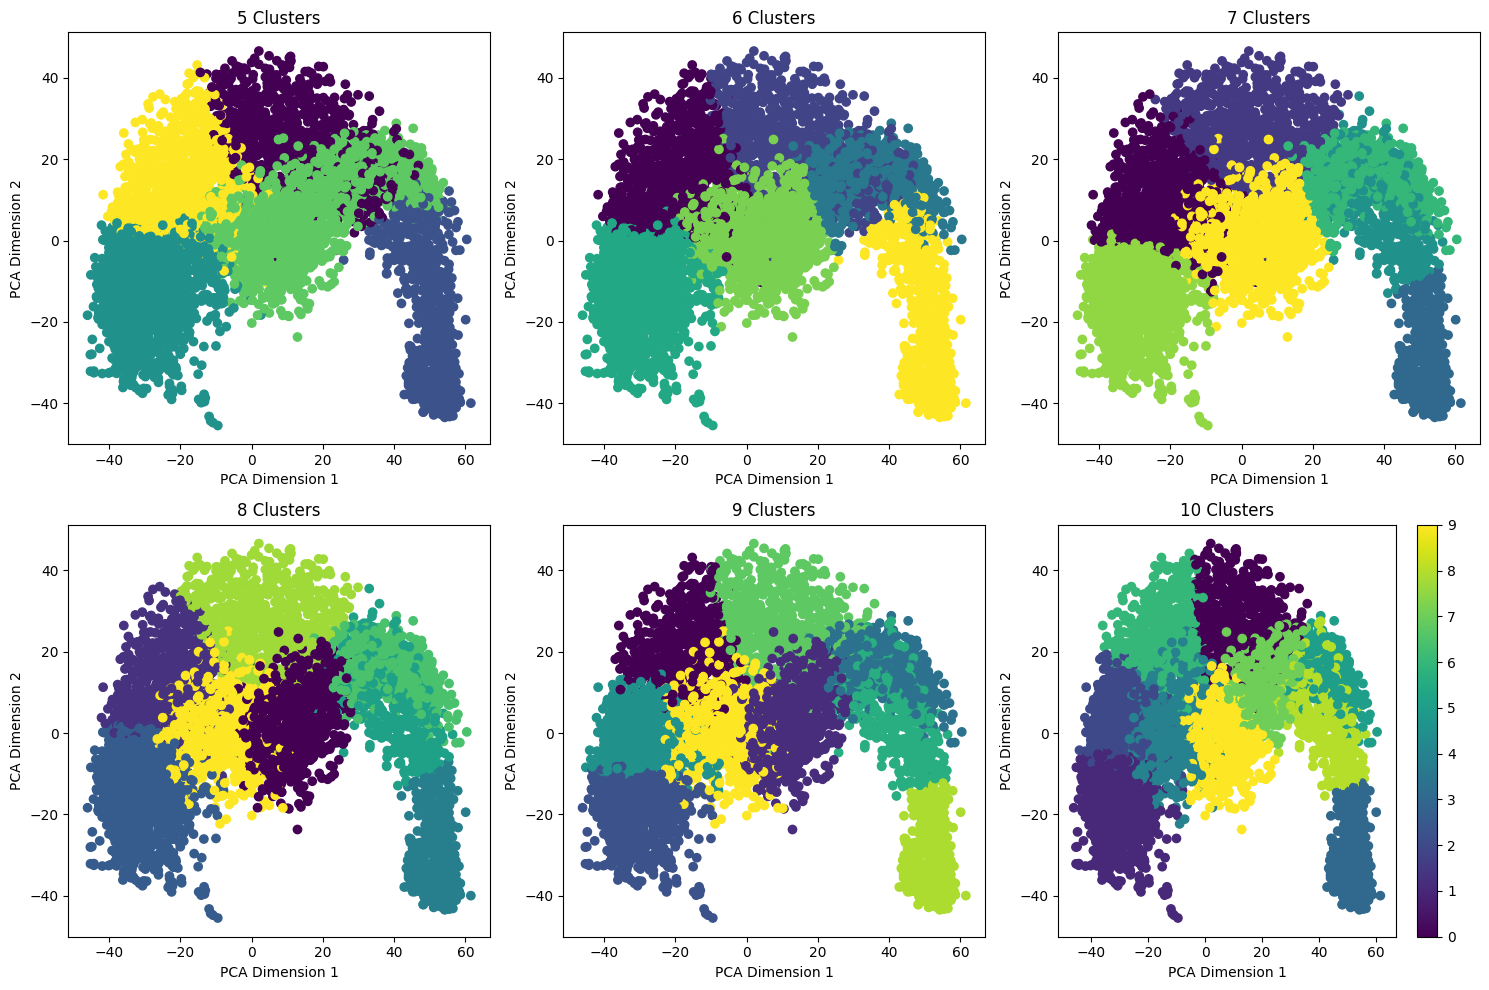

In [54]:
cluster_numbers = range(5, 11)
fig, axs = plt.subplots(2, 3, figsize=(15, 10))
axs = axs.flatten()

for i, n_clusters in enumerate(cluster_numbers):
    centroids, _ = kmeans(features_pca, n_clusters)
    clusters, _ = vq(features_pca, centroids)
    scatter = axs[i].scatter(features_pca[:, 0], features_pca[:, 1], c=clusters, cmap='viridis')
    axs[i].set_title(f'{n_clusters} Clusters')
    axs[i].set_xlabel('PCA Dimension 1')
    axs[i].set_ylabel('PCA Dimension 2')

for j in range(i + 1, len(axs)):
    fig.delaxes(axs[j])

fig.colorbar(scatter, ax=axs[i], orientation='vertical')

plt.tight_layout()
plt.show()

